In [ ]:
# !pip install protobuf==3.20.3 --force-reinstall

# LLM Decoding Strategy Analysis

In [4]:
from transformers import AutoModelForCausalLM, AutoTokenizer, AutoModelForSequenceClassification
import torch
import numpy as np

import importlib

In [5]:
import task1_gem as t
importlib.reload(t)

Running on device: cuda
Running on device: cuda


<module 'task1_gem' from '/kaggle/working/ATML-FINAL/task1_gem.py'>

## Loading Dataset and Models

In [6]:
MODEL_ID = "HuggingFaceTB/SmolLM2-135M-SFT-Only"
REWARD_MODEL_ID = "weqweasdas/RM-Gemma-2B"#"OpenAssistant/reward-model-deberta-v3-large-v2"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [7]:
print(f"Running on device: {DEVICE}")

Running on device: cuda


In [8]:
# Load Models
print("Loading SFT Model...")
model = AutoModelForCausalLM.from_pretrained(MODEL_ID, torch_dtype=torch.float16).to(DEVICE)
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)

Loading SFT Model...


/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

In [9]:
# Load Reward Model (Quality Metric)
print("Loading Reward Model...")
try:
    rm_tokenizer = AutoTokenizer.from_pretrained(REWARD_MODEL_ID)
    rm_model = AutoModelForSequenceClassification.from_pretrained(REWARD_MODEL_ID, torch_dtype=torch.float16).to(DEVICE)
except Exception as e:
    print(f"Error loading reward model: {e}")
    print("Continuing without quality scoring...")
    rm_model = None
    rm_tokenizer = None

Loading Reward Model...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [10]:
from datasets import load_dataset, Dataset, concatenate_datasets
# -----------------------------
# 1. Load 250 examples from each dataset
# -----------------------------
ds_alpaca = load_dataset("tatsu-lab/alpaca", split="train[:150]")

def standardize(example):
    # Many instruction datasets have 'instruction', 'input', 'output' or similar
    # We'll unify to 'instruction', 'input', 'output'
    standardized = {
        "instruction": example.get("instruction", ""),
        "input": example.get("input", ""),       # some datasets may not have input
        "output": example.get("output", example.get("response", ""))  # fallback to 'response'
    }
    return standardized

In [11]:
ds_alpaca = ds_alpaca.map(standardize)

In [12]:
ds = ds_alpaca

In [13]:
# Define Test Data (Instruction-Following Subset)
# prompts = [
#     "Explain quantum entanglement to a 5 year old.",
#     "Write a python function to merge two sorted lists.",
#     "Give me a recipe for chocolate chip cookies.",
#     "What are the main causes of the French Revolution?",
#     "Compose a haiku about artificial intelligence."
# ]

prompts = [str(item['instruction'])[:2000] for item in ds]

In [14]:
# Parameters
temperatures = [0.2, 0.5, 0.8, 1.0, 1.2]
# thresholds_p = [0.2, 0.5, 0.8, 0.9, 0.99]
# thresholds_k = [3, 10, 50, 100, 500]
beam_width = 3
top_k_val = 50
top_p_val = 0.9

results_log = []

## Starting Analysis of Diversity vs Quality Trade-off of Top-K vs Top-P Varying Temperature

In [15]:
from tqdm import tqdm

In [18]:
temp_quality_exp = []
temp_diversity_exp = []

for T in temperatures:
    bar = tqdm(prompts, ncols=100)
    for i, prompt in enumerate(bar):
        bar.set_description(f"T={T} | Prompt {i+1}/{len(prompts)}")
        # Top-K
        res_k = t.top_k_sampling(model, tokenizer, prompt, k=top_k_val, temperature=T)
        score_k = t.get_reward_score(rm_model, rm_tokenizer, prompt, res_k) if rm_model else 0
        
        # Top-P
        res_p = t.top_p_sampling(model, tokenizer, prompt, p=top_p_val, temperature=T)
        score_p = t.get_reward_score(rm_model, rm_tokenizer, prompt, res_p) if rm_model else 0
        
        temp_quality_exp.append({"Strategy": "Top-K", "Temp": T, "Score": score_k, "Prompt": prompt})
        temp_quality_exp.append({"Strategy": "Top-P", "Temp": T, "Score": score_p, "Prompt": prompt})

        temp_diversity_exp.append({"Strategy": "Top-K", "Temp": T, "Response": res_k, "Prompt": prompt})
        temp_diversity_exp.append({"Strategy": "Top-P", "Temp": T, "Response": res_p, "Prompt": prompt})

T=0.2 | Prompt 300/300: 100%|█████████████████████████████████████| 300/300 [06:40<00:00,  1.33s/it]
T=0.5 | Prompt 300/300: 100%|█████████████████████████████████████| 300/300 [07:24<00:00,  1.48s/it]
T=0.8 | Prompt 300/300: 100%|█████████████████████████████████████| 300/300 [07:20<00:00,  1.47s/it]
T=1.0 | Prompt 300/300: 100%|█████████████████████████████████████| 300/300 [07:40<00:00,  1.53s/it]
T=1.2 | Prompt 300/300: 100%|█████████████████████████████████████| 300/300 [08:50<00:00,  1.77s/it]


### Results

In [19]:
print("\n--- Graphing Results of All 3 Experiments ---")
import matplotlib.pyplot as plt
import pandas as pd

# Convert experiment logs into DataFrames
df_temp_q = pd.DataFrame(temp_quality_exp)


--- Graphing Results of All 3 Experiments ---


#### Quality-Temperature Sweep Plot

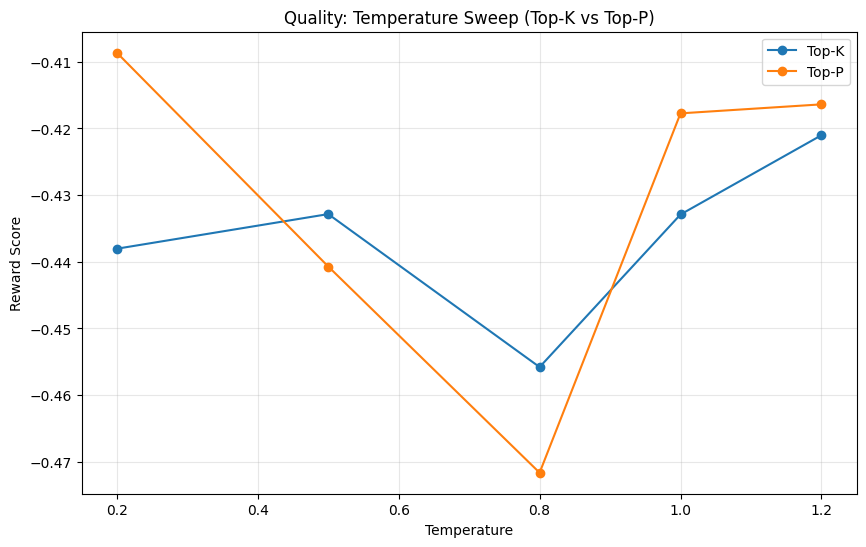

In [20]:
# -----------------------------
# 1. Temperature Sweep Plot
# -----------------------------
plt.figure(figsize=(10, 6))

for strategy in df_temp_q["Strategy"].unique():
    subset = df_temp_q[df_temp_q["Strategy"] == strategy]
    # Average across prompts if multiple prompts
    grouped = subset.groupby("Temp")["Score"].mean()
    plt.plot(grouped.index, grouped.values, marker='o', label=strategy)

plt.title("Quality: Temperature Sweep (Top-K vs Top-P)")
plt.xlabel("Temperature")
plt.ylabel("Reward Score")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

In [16]:
def calculate_aggregated_distinct_n(texts):
    """
    Computes (Unique D1 + Unique D2 + Unique D3) / (Total D1 + Total D2 + Total D3)
    """
    unique_ngrams = 0
    total_ngrams = 0
    
    for n in [1, 2, 3]:
        if not texts:
            continue
        
        all_ngrams = []
        for text in texts:
            words = text.split()
            ngrams = [tuple(words[i:i+n]) for i in range(len(words)-n+1)] if len(words) >= n else []
            all_ngrams.extend(ngrams)
        
        unique_ngrams += len(set(all_ngrams))
        total_ngrams += len(all_ngrams)
    
    if total_ngrams == 0:
        return 0.0
    return unique_ngrams / total_ngrams


#### Diversity-Temperature Sweep Plot

In [22]:
div_temp = []

for T in temperatures:
    for strategy in ["Top-K", "Top-P"]:
        # Collect all generated texts at this temperature for this strategy
        texts = [record["Response"] for record in temp_diversity_exp
                 if record["Temp"] == T and record["Strategy"] == strategy]
        
        agg_dn = calculate_aggregated_distinct_n(texts)
        div_temp.append({"Strategy": strategy, "Temp": T, "Aggregated_DN": agg_dn})

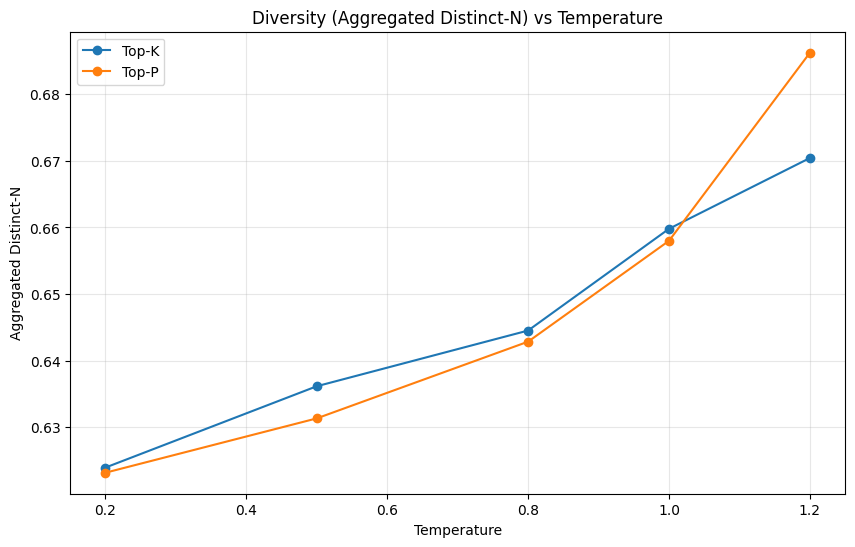

In [23]:
df_div_temp = pd.DataFrame(div_temp)

# Plot
plt.figure(figsize=(10,6))
for strategy in df_div_temp["Strategy"].unique():
    subset = df_div_temp[df_div_temp["Strategy"] == strategy]
    plt.plot(subset["Temp"], subset["Aggregated_DN"], marker='o', label=strategy)

plt.title("Diversity (Aggregated Distinct-N) vs Temperature")
plt.xlabel("Temperature")
plt.ylabel("Aggregated Distinct-N")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

## Analysis of Across-Prompt vs Within Prompt Diversity across all Decoding Strategies

In [17]:
print("\n--- Starting Analysis of Across-Prompt vs Within Prompt Diversity across all Decoding Strategies ---")

# 1. Across Prompt
greedy_responses = []
beam_responses = []
top_k_responses = []
top_p_responses = []


--- Starting Analysis of Across-Prompt vs Within Prompt Diversity across all Decoding Strategies ---


In [10]:
print("Running Decoding Strategies for Across Prompt...")
for prompt in prompts:
    # Greedy
    res_g = t.greedy_search(model, tokenizer, prompt)
    greedy_responses.append(res_g)
    
    # Beam
    res_b = t.beam_search(model, tokenizer, prompt, beam_width=beam_width)
    beam_responses.append(res_b)
    
    # Top-K
    res_k = t.top_k_sampling(model, tokenizer, prompt, temperature=0.8)
    top_k_responses.append(res_k)

    # Top-P
    res_p = t.top_p_sampling(model, tokenizer, prompt, temperature=0.8)
    top_p_responses.append(res_p)

Running Decoding Strategies for Across Prompt...


NameError: name 't' is not defined

In [18]:
def compute_avg_reward(responses):
    scores = []
    bar = tqdm(zip(prompts, responses), ncols=100)
    for prompt, resp in bar:
        s = t.get_reward_score(rm_model, rm_tokenizer, prompt, resp)
        scores.append(s)
    return np.mean(scores)

In [27]:
quality_across = {
    "Greedy": compute_avg_reward(greedy_responses),
    "Beam": compute_avg_reward(beam_responses),
    "Top-K": compute_avg_reward(top_k_responses),
    "Top-P": compute_avg_reward(top_p_responses),
}

print("\n[Quality Analysis for Across Prompt]")
print(quality_across)

300it [00:10, 28.59it/s]
300it [00:10, 29.00it/s]
300it [00:10, 27.82it/s]
300it [00:10, 27.36it/s]


[Quality Analysis for Across Prompt]
{'Greedy': -0.41594435056050616, 'Beam': -0.8478425820668538, 'Top-K': -0.4414375782012939, 'Top-P': -0.4364221541086833}


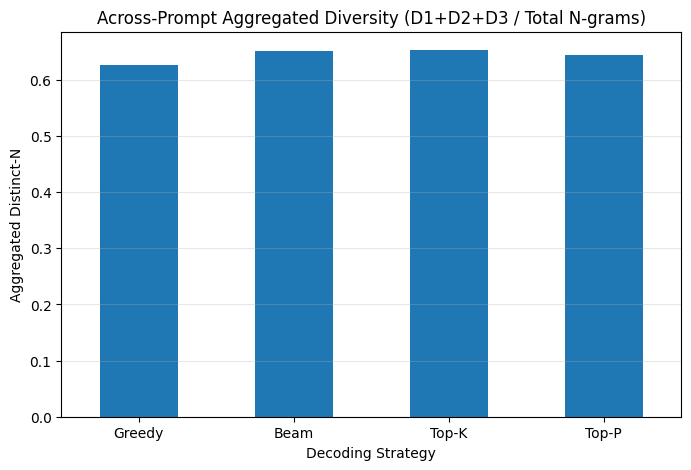

In [28]:
div_across_agg = {
    "Greedy": calculate_aggregated_distinct_n(greedy_responses),
    "Beam": calculate_aggregated_distinct_n(beam_responses),
    "Top-K": calculate_aggregated_distinct_n(top_k_responses),
    "Top-P": calculate_aggregated_distinct_n(top_p_responses),
}

# Convert to DataFrame for plotting
df_across_agg = pd.DataFrame.from_dict(div_across_agg, orient="index", columns=["Aggregated DN"])

# Plot
df_across_agg.plot(kind="bar", figsize=(8,5), legend=False)
plt.title("Across-Prompt Aggregated Diversity (D1+D2+D3 / Total N-grams)")
plt.ylabel("Aggregated Distinct-N")
plt.xlabel("Decoding Strategy")
plt.xticks(rotation=0)
plt.grid(axis="y", alpha=0.3)
plt.show()


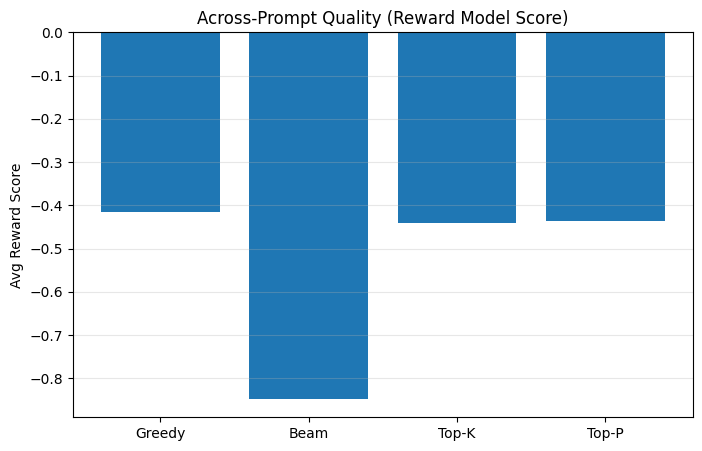

In [29]:
# ---------- Graph 1: Across-Prompt Quality ----------
plt.figure(figsize=(8,5))
plt.bar(quality_across.keys(), quality_across.values())
plt.title("Across-Prompt Quality (Reward Model Score)")
plt.ylabel("Avg Reward Score")
plt.grid(axis="y", alpha=0.3)
plt.show()

In [19]:
# --------------------------------------------------------------
# 4. WITHIN-PROMPT DIVERSITY (generate N samples for same prompt)
# --------------------------------------------------------------

NUM_SAMPLES = len(prompts)   # same N as across-prompt

test_prompt = prompts[0]     # fixed prompt

In [20]:
def sample_n(strategy_fn, name):
    results = []
    for _ in range(NUM_SAMPLES):
        results.append(strategy_fn())
    return results

In [21]:
within_responses = {
    "Greedy": sample_n(lambda: t.greedy_search(model, tokenizer, test_prompt), "Greedy"),
    "Beam": sample_n(lambda: t.beam_search(model, tokenizer, test_prompt, beam_width=beam_width), "Beam"),
    "Top-K": sample_n(lambda: t.top_k_sampling(model, tokenizer, test_prompt, temperature=0.8), "Top-K"),
    "Top-P": sample_n(lambda: t.top_p_sampling(model, tokenizer, test_prompt, temperature=0.8), "Top-P"),
}

In [ ]:
div_within = {}

for strat, texts in within_responses.items():
    div_within[strat] = {
        "DN": calculate_aggregated_distinct_n(texts)
    }

print("\n[Diversity Analysis for Within Prompt]")
print(div_within)


[Diversity Analysis for Within Prompt]
{'Greedy': {'DN': 0.0033333333333333335}, 'Beam': {'DN': 0.0033333333333333335}, 'Top-K': {'DN': 0.30013090562894207}, 'Top-P': {'DN': 0.2920622863653627}}


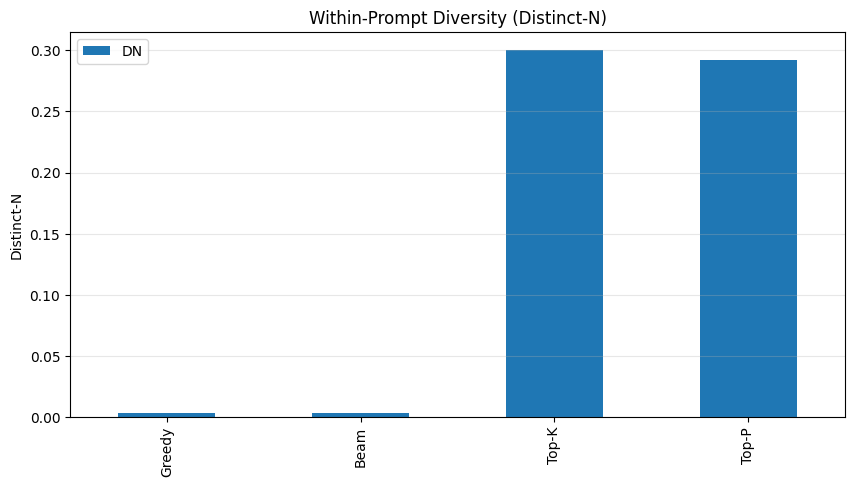

In [34]:
# ---------- Graph 3: Within-Prompt Diversity ----------
df_within = pd.DataFrame(div_within).T
df_within.plot(kind="bar", figsize=(10,5))
plt.title("Within-Prompt Diversity (Distinct-N)")
plt.ylabel("Distinct-N")
plt.grid(axis="y", alpha=0.3)
plt.show()

In [26]:
quality_within = {}

for strat, texts in within_responses.items():
    quality_within[strat] = {
        "Avg Reward": compute_avg_reward(texts)
    }

print("\n[Quality Analysis for Within Prompt]")
print(quality_within)

150it [00:03, 37.67it/s]
150it [00:03, 38.15it/s]
150it [00:04, 37.06it/s]
150it [00:04, 37.32it/s]


[Quality Analysis for Within Prompt]
{'Greedy': {'Avg Reward': -1.00798095703125}, 'Beam': {'Avg Reward': -1.00798095703125}, 'Top-K': {'Avg Reward': -0.9074662272135416}, 'Top-P': {'Avg Reward': -0.9790922037760417}}


In [29]:
import pandas as pd
import matplotlib.pyplot as plt

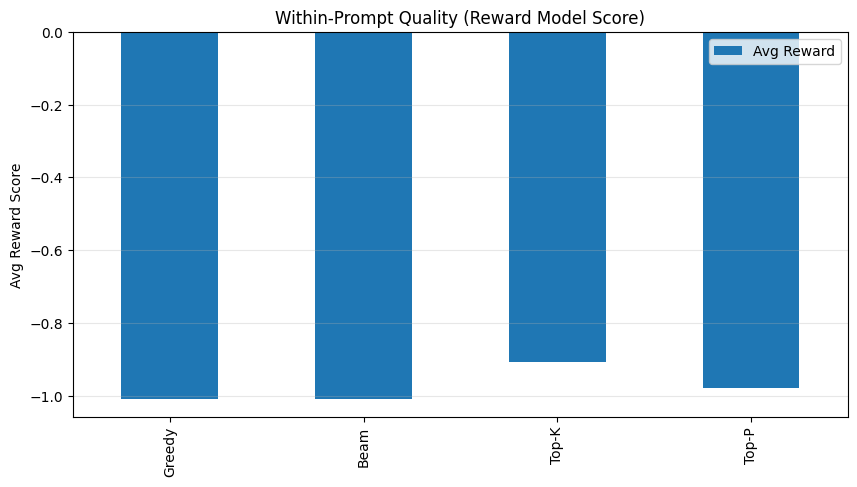

In [30]:
# ---------- Graph 4: Within-Prompt Quality ----------
df_within = pd.DataFrame(quality_within).T
df_within.plot(kind="bar", figsize=(10,5))
plt.title("Within-Prompt Quality (Reward Model Score)")
plt.ylabel("Avg Reward Score")
plt.grid(axis="y", alpha=0.3)
plt.show()